In [499]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns',None)

In [500]:
df = pd.read_csv('heart.csv')

In [501]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


we will first check for nan values.

In [502]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

As you can see there are no nan values present in the dataset.

We will extract all the features.

In [503]:
features = [feature for feature in df.columns if feature!= 'target']

Dividing it into Discrete and Continous.

In [504]:
dis_feature = [ feature for feature in features if len(df[feature].unique()) < 10 ]

In [505]:
dis_feature

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

We will go for count plot for understanding insight of data.

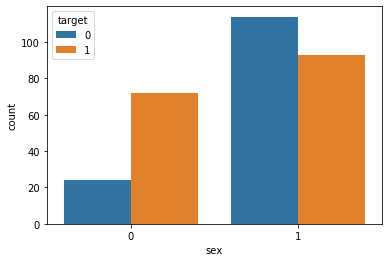

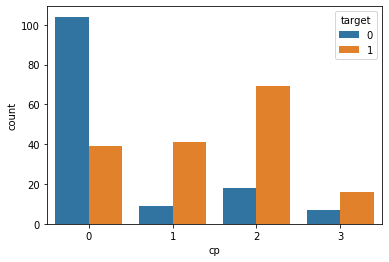

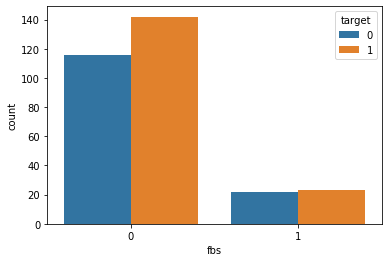

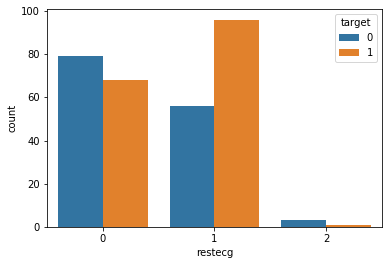

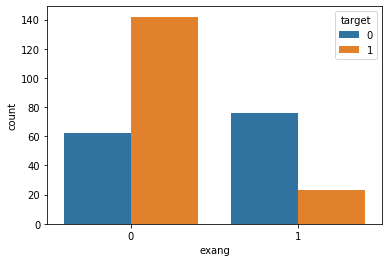

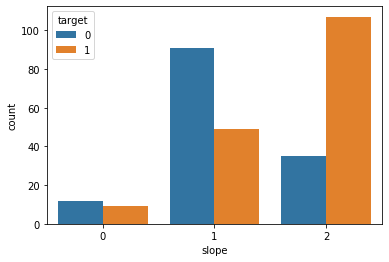

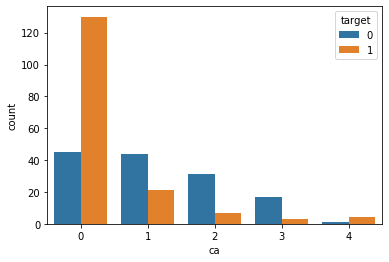

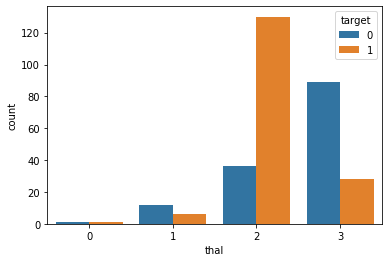

In [506]:
for feature in dis_feature:
    sns.countplot(x=feature,data=df,hue='target')
    plt.xlabel(feature)
    plt.ylabel('count')
    plt.show()

From above,

            1 : cp,ca,slope,thal are playing important role with respect to target.
            2 : fbs has 50-50% probability. so,it is weak to predict the target

Relationship of every feature with respect to target.

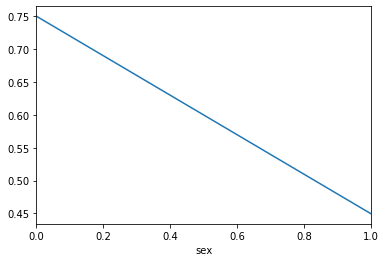

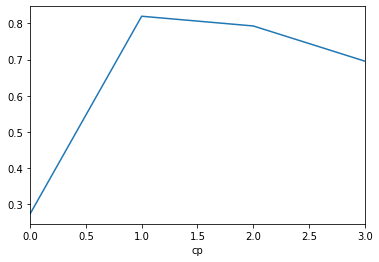

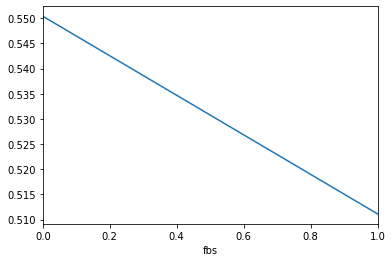

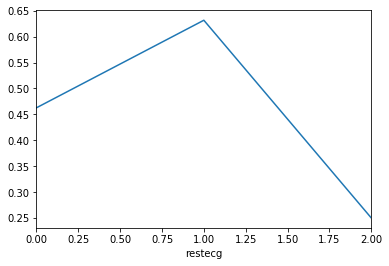

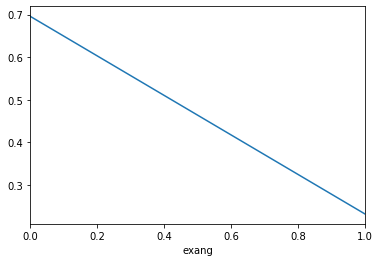

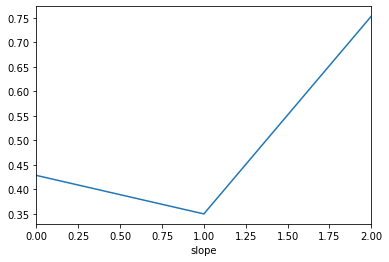

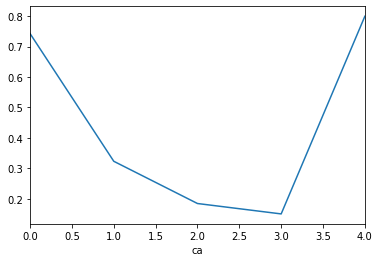

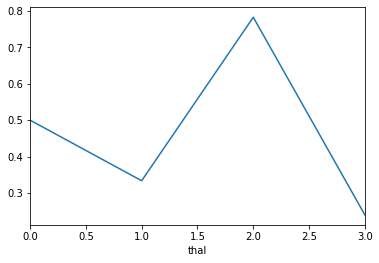

In [507]:
for feature in dis_feature:
    df.groupby(feature)['target'].mean().plot()
    plt.xlabel(feature)
    plt.show()

As, they are not in perfect relationship, we will bring it to monotonic relationship with the help of target guided encoding. 

In [508]:
for feature in dis_feature:
    mean = df.groupby(feature)['target'].mean()
    index = mean.sort_values().index
    ordered_labels = { k:i for i,k in enumerate(index,0) }
    df[feature] = df[feature].map(ordered_labels)
    

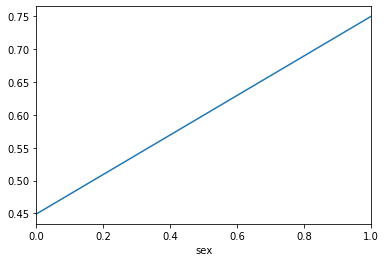

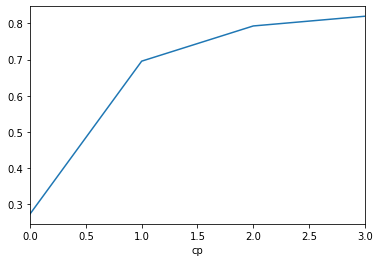

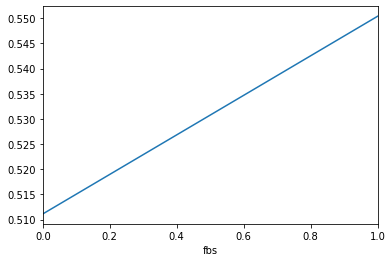

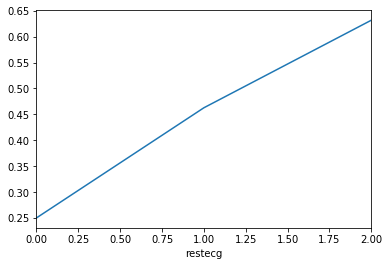

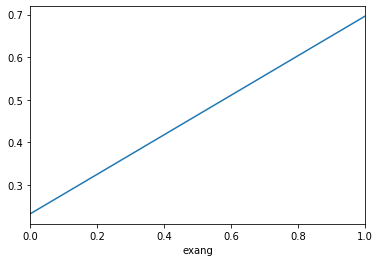

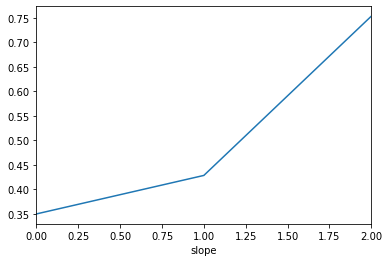

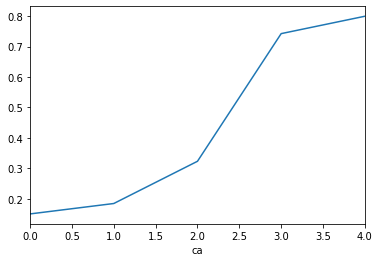

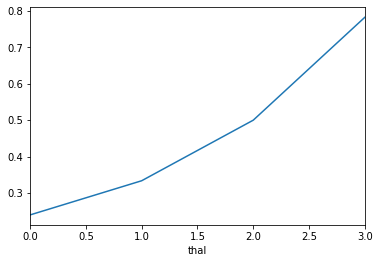

In [509]:
for feature in dis_feature:
    df.groupby(feature)['target'].mean().plot()
    plt.xlabel(feature)
    plt.show()

As you can see, all the features are now in monotonic relationship. 

Extracting Continous features.

In [510]:
con_feature = [ feature for feature in features if feature not in dis_feature]

In [511]:
con_feature

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

First and foremost we will check histogram of each feature. 

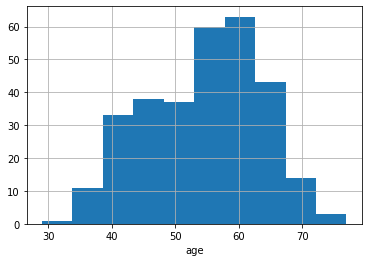

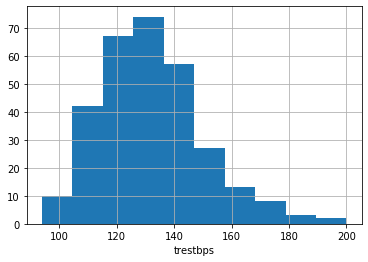

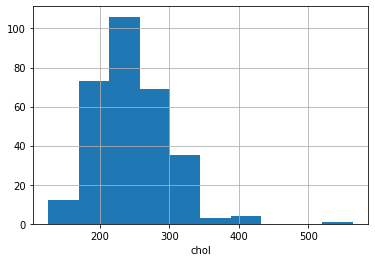

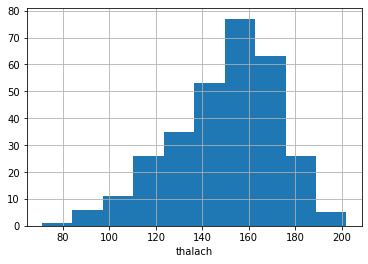

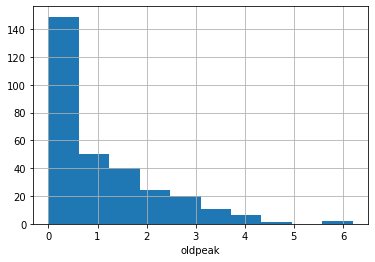

In [512]:
for feature in con_feature:
    df[feature].hist(bins=10)
    plt.xlabel(feature)
    plt.show()

Above all the features, oldpeak is highly skewed.

The 1/3 rd of oldpeak are 0(zeros). so,we will use it as it is.

According to above histograms, there we will be very few outliers.

Now, we will check for outliers

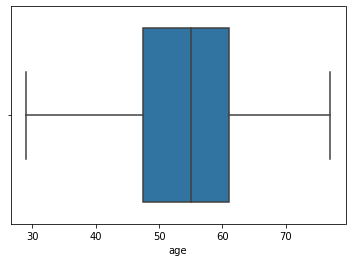

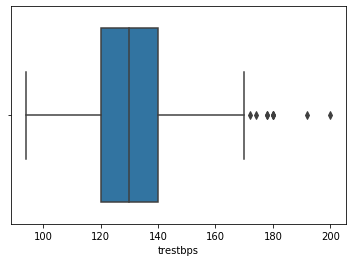

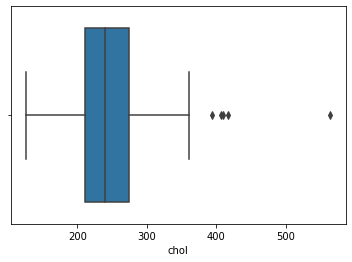

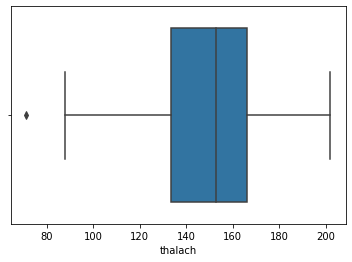

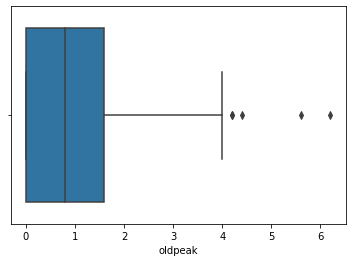

In [513]:
for feature in con_feature:
    sns.boxplot(x=feature,data=df)
    plt.show()

As predicted there are very few outliers.

For Feature selection, we are using SelectKbest and chi2

In [514]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [515]:
selectk = SelectKBest(score_func=chi2,k=7)

In [516]:
feature_scores = selectk.fit(df.drop('target',axis=1),df['target'])

In [517]:
feature_scores.scores_

array([2.32866240e+01, 1.63375494e+01, 9.00635190e+01, 1.48239245e+01,
       2.39363945e+01, 3.53954101e-02, 1.85536314e+00, 1.88320472e+02,
       1.88849182e+01, 7.26442530e+01, 4.28166967e+01, 2.51831320e+01,
       1.02245062e+02])

In [518]:
df_scores = pd.DataFrame(feature_scores.scores_)
df_features = pd.DataFrame(features)

In [519]:
features_scores = pd.concat([df_features,df_scores],axis=1)

In [520]:
features_scores.columns = ['features','scores']

In [521]:
features_scores.sort_values(by='scores',ascending=False,inplace=True)

In [522]:
features_scores

,features,scores
7,thalach,188.320472
12,thal,102.245062
2,cp,90.063519
9,oldpeak,72.644253
10,slope,42.816697
11,ca,25.183132
4,chol,23.936394
0,age,23.286624
8,exang,18.884918
1,sex,16.337549


As I already discussed in Feature engneering cp,thal are more correlated with target.

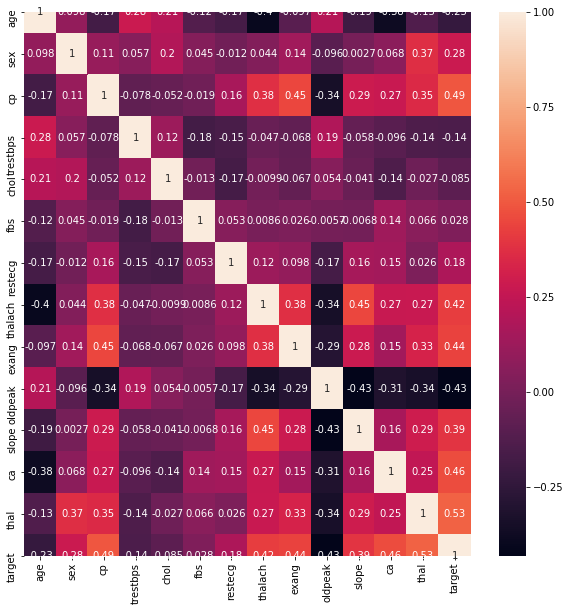

In [523]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True)

There are many features with correlation more than 0.4.

Extracting those features which scored more than 18.

In [524]:
Best_features = features_scores[features_scores['scores']>18]['features'].values

In [525]:
Best_features

array(['thalach', 'thal', 'cp', 'oldpeak', 'slope', 'ca', 'chol', 'age',
       'exang'], dtype=object)

We are using Ensemble technique because it does not over fit. 

In [560]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [527]:
model = RandomForestClassifier()

In [559]:
cross_val_score(model,df[Best_features],df['target'],cv=10).mean()

0.8250537634408601

As you can see we have got 82% accuracy


We will tune the parameters of Random Forest to improve further accuracy.

In [529]:
from sklearn.model_selection import RandomizedSearchCV

In [530]:
params = {
    'n_estimators' : list(np.arange(10,101,1)),
    'max_depth' :  list(np.arange(3,30,1)),
    'min_samples_leaf' :  list(np.arange(1,10,1)),
    'min_samples_split' :  list(np.arange(1,10,1))
}

In [531]:
random_search = RandomizedSearchCV(model,param_distributions=params,n_jobs=-1,n_iter=10,scoring='f1_macro',cv=5,verbose=3)

In [532]:
random_search.fit(df[Best_features],df['target'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.9s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [533]:
random_search.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [534]:
model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=22, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=41,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [539]:
cross_val_score(model,df[Best_features],df['target'],cv=10).mean()

0.8480645161290322

As you can see,Hyper Parameter tuninig improved accuracy to 84%

#### I hope you learned some new things...

#### Thank You.